# Code for bot analysis in _Handbook of Computational Social Science_

#### _Simon Lindgren_
----

Import packages.

In [29]:
import pandas as pd
import ast
import json
from pywaffle import Waffle
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
from gensim import corpora, models
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel

import squarify  


----
#### 1. Example of bot dection scores

Based on a dataset of #antifa tweets (2016-2020, n = ~5.7M), we have data from the Botometer API for the top 10k users based on posting volume.

Parse these botscores:

In [77]:
caps = []
types = []
userids = []

with open('antifa-botscores.txt', 'r') as data:
    for i in data:
        try:
            i = ast.literal_eval(i)[1]
            cap = i['cap']['english']
            caps.append(cap)
            typedict = i['display_scores']['english']
            bottype = max(typedict, key=typedict.get)
            types.append(bottype)
            userid = i['user']['user_data']['id_str']
            userids.append(userid)
        except:
            pass

df = pd.DataFrame(zip(userids,caps,types))
df.columns = ['user_id', 'cap', 'type']

Visualise the share of bot accounts.

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


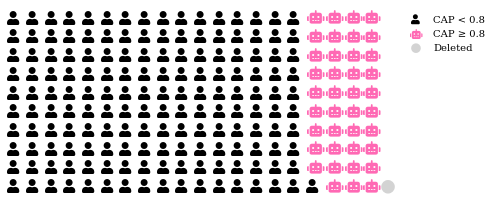

In [78]:
threshold = 0.8
botshare = len(df.cap[df.cap > threshold]) / len(df.cap)

deleted = round((10000 - len(df)) / 50) # some accounts were not found by Botometer
bots = round((botshare * 10000) / 50)
humans = round((10000/50) * (1-botshare))

myfont1 = mpl.font_manager.FontProperties(fname="Roboto")

fig = plt.figure(
    FigureClass=Waffle,
    figsize = (7,20),
    rows=10,
    values=[humans, bots, deleted],
    colors=["black", "hotpink", "lightgrey"],
    icons=['user', 'robot', 'circle'],
    font_size=14,
    icon_style='solid',
    icon_legend=True,
    legend={
        'frameon' : False,
        'labels': ['CAP < 0.8', 'CAP ≥ 0.8', 'Deleted'], 
        'loc': 'upper left', 
        'bbox_to_anchor': (1, 1),
    }
)

plt.savefig('antifa.png', dpi=300)
plt.savefig('antifa.pdf', dpi=300)

----
#### 2. SNA example

We have a csv edgelist based on mentions between accounts in the dataset.

In [93]:
edgesDF.to_csv('antifa.csv', index = False) # to Gephi

The csv was exported and analysed in Gephi, as described in the chapter.

After initial processing in Gephi, 2090 nodes remained in the visualisation.

Read their data based on Botometer API, and prepare csv with 'images' column for import in Gephi:

In [92]:
ids = []
images = []

with open("gephi-botscores.txt", "r") as raw:
    
    bot_treshold = 0.8
    userid = []
    for i in raw:
        i = ast.literal_eval(i)
        ids.append(i[1]['user']['user_data']['id_str'])
        cap = i[1]['cap']['english']
        if cap >= 0.8:
            images.append('bot.png')
        else:
            images.append('human.png')  
    

In [93]:
botsDF = pd.DataFrame(zip(ids, images))
botsDF.columns = ['Id', 'image']

In [191]:
botsDF.dtypes

Id       object
image    object
dtype: object

In [192]:
botsDF.to_csv("node_image_attrib.csv", index = False)

The _Image Preview_ plugin for Gephi enabled visualising the network with icons for nodes. Numbered boxes were added in separate image editing software.

![alt text](network.png)

----
#### 3. LDA example

Reading all non–retweets from the #antifa dataset.

In [146]:
users = []
tweets = []

with open('/path-to-dataset/antifa.jsonl') as indata:
    for i in indata:
        i = json.loads(i)
        for d in i['data']:            
            if not d['text'].startswith('RT'):
                users.append(d['author_id'])
                tweets.append(d['text'])

FileNotFoundError: [Errno 2] No such file or directory: '/path-to-dataset/antifa.jsonl'

In [149]:
len(tweets)

1302505

In [171]:
ldaDF = pd.DataFrame(zip(users,tweets))

In [172]:
ldaDF.columns=['user', 'tweet']

In [173]:
df_grouped = ldaDF.groupby('user')

NameError: name 'ldaDF' is not defined

In [189]:
usrs = []
twts = []

for user, df_group in df_grouped:
    usrs.append(user)
    twt = []
    for t in df_group.tweet:
        for w in t:
            twt.append(w)
    twts.append(' '.join(list(set(twt))))

NameError: name 'df_grouped' is not defined

Preprocessing ahead of LDA:

In [190]:
docs = twts

In [191]:
# Tokenize the documents.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [192]:
# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [193]:
# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [194]:
# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur in less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [195]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [196]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 53787
Number of documents: 216387


Train the LDA model:

In [197]:
# Set training parameters.
num_topics = 20
chunksize = 2000
passes = 10
iterations = 200
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

After manually inspecting the topics using

```
top_topics = model.top_topics(corpus)

for c,t in enumerate(top_topics):
    print(str(c) + ' ============\n')
    for i in t[0]:
        print(i[1])
    print('\n\n')
````


it was found that topics 14 and 3 were representative of anti-antifa discourse and antifa discourse respectively.

Tag users by their top topics.

In [235]:
user_category = []
antianti = [14]
antifa = [3]

# Get the top topic for each user
for user in model[corpus]:
    top_topic = max(dict(user), key=dict(user).get)
    
    if top_topic in antianti:
        user_category.append('antiantifa')
        
    if top_topic in antifa:
        user_category.append('antifa')
    
    else:
        user_category.append('0')

Add in bot detection data.

In [246]:
viewsDF = pd.DataFrame(zip(usrs,user_category))
viewsDF.columns = ['user', 'pos']
viewsDF = viewsDF[viewsDF.pos != '0']

dfX = pd.merge(viewsDF,botsDF, on = 'user')

species = []
for i in dfX.image:
    if i == 'human.png':
        species.append('humanoid')
    else:
        species.append('bot')

dfX['image'] = species

dfX.columns = ['user', 'pos', 'species']

dfX.head()

NameError: name 'usrs' is not defined

In [247]:
dfX['kind'] = dfX.pos + '_' + dfX.species

In [256]:
dfX.kind.value_counts()

antiantifa_humanoid    35
antifa_humanoid        12
antiantifa_bot          4
Name: kind, dtype: int64

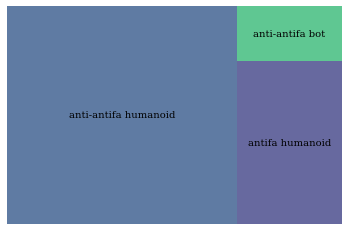

In [75]:
# Create a data frame
df = pd.DataFrame({'size':[35,12,4], 'group':["anti-antifa humanoid", "antifa humanoid", "anti-antifa bot"] })

# Plot it
squarify.plot(sizes=df['size'], label=df['group'], alpha=.8 )

plt.axis('off')

plt.savefig('botplot.pdf')  
plt.show()